In [28]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from extra_keras_metrics import average_precision_at_k


import tensorflow as tf

# Set some parameters
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_CHANNELS = 25
TRAIN_PATH = 'GeneratedData/train/'
TEST_PATH = 'GeneratedData/test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [29]:
# Get train and test ids
train_ids = np.loadtxt(TRAIN_PATH + 'Directory.txt').astype(int)
test_ids = np.loadtxt(TEST_PATH + 'Directory.txt').astype(int)

In [30]:
print("train ids(%i):" % (len(train_ids)), train_ids, "\n")
print("test ids(%i):" % (len(test_ids)), test_ids)

train ids(5000): [317877256 317877296 317877348 ... 318090414 318090481 318090551] 

test ids(500): [318580722 318580765 318580800 318580840 318580874 318580933 318580966
 318581016 318581076 318581125 318581189 318581242 318581302 318581325
 318581365 318581401 318581471 318581508 318581559 318581599 318581629
 318581662 318581700 318581734 318581778 318581825 318581861 318581916
 318581955 318581990 318582023 318582067 318582104 318582147 318582184
 318582230 318582274 318582321 318582345 318582385 318582416 318582477
 318582511 318582553 318582600 318582651 318582688 318582743 318582772
 318582795 318582835 318582887 318582934 318582968 318583023 318583068
 318583110 318583151 318583193 318583242 318583289 318583335 318583374
 318583416 318583447 318583488 318583518 318583555 318583605 318583654
 318583689 318583719 318583766 318583799 318583837 318583875 318583924
 318583989 318584032 318584077 318584115 318584149 318584182 318584218
 318584246 318584283 318584326 318584386 3185844

# Data processing

In [31]:
X_train = np.zeros((len(train_ids), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

# Get train images and masks
print('Getting train images and masks ... ')
sys.stdout.flush()
for n, id in tqdm(enumerate(train_ids), total=len(train_ids)):
    img_path = TRAIN_PATH + 'ImageMap-' + str(id) + '.dat'
    img_zxy = np.fromfile(img_path, dtype='uint8')
    img_zxy.shape = (IMG_CHANNELS, IMG_WIDTH, IMG_HEIGHT)
    # convert from 25x64x64 to 64x64x25
    img_xyz = np.zeros((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    for i in range(IMG_CHANNELS):
        img_xyz[:,:,i] = img_zxy[i,:,:]
    X_train[n] = img_xyz
    
    mask_path = TRAIN_PATH + 'LabelMap-' + str(id) + '.dat'
    mask = np.fromfile(mask_path, dtype=np.bool)
    mask.shape = (IMG_WIDTH, IMG_HEIGHT, 1)
    Y_train[n] = mask

# Get test images and masks
print('Getting test images and masks ... ')
sys.stdout.flush()
X_test = np.zeros((len(test_ids), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
for n, id in tqdm(enumerate(test_ids), total=len(test_ids)):
    img_path = TEST_PATH + 'ImageMap-' + str(id) + '.dat'
    img_zxy = np.fromfile(img_path, dtype='uint8')
    img_zxy.shape = (IMG_CHANNELS, IMG_WIDTH, IMG_HEIGHT)
    # convert from 25x64x64 to 64x64x25
    img_xyz = np.zeros((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    for i in range(IMG_CHANNELS):
        img_xyz[:,:,i] = img_zxy[i,:,:]
    X_test[n] = img_xyz
    
    mask_path = TEST_PATH + 'LabelMap-' + str(id) + '.dat'
    mask = np.fromfile(mask_path, dtype=np.bool)
    mask.shape = (IMG_WIDTH, IMG_HEIGHT, 1)
    Y_test[n] = mask

print("Done!")

Getting train images and masks ... 


100%|██████████| 5000/5000 [00:04<00:00, 1039.77it/s]

Getting test images and masks ... 



100%|██████████| 500/500 [00:00<00:00, 1157.50it/s]

Done!


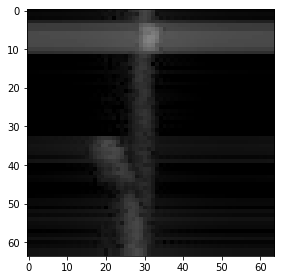

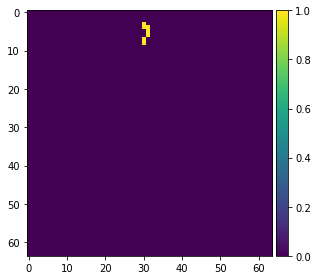

In [32]:
# Check if training data looks okay
img_idx = random.randint(0, len(train_ids)-1)
color_idx = random.randint(0, IMG_CHANNELS-1)
imshow(X_train[img_idx,:,:,color_idx])
plt.show()
imshow(np.squeeze(Y_train[img_idx]))
plt.show()

# Create model

Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [49]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Normalize inputs
# s = Lambda(lambda x: x / 255) (inputs)
s = inputs

# Encoder layers
conv0 = Conv2D(4, (3, 3), activation='relu', padding='same') (s)
conv0 = Dropout(0.2)(conv0)
conv0 = Conv2D(4, (3, 3), activation='relu', padding='same') (conv0)
pool0 = MaxPooling2D((2, 2)) (conv0)

conv1 = Conv2D(8, (3, 3), activation='relu', padding='same') (pool0)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(8, (3, 3), activation='relu', padding='same') (conv1)
pool1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(16, (3, 3), activation='relu', padding='same') (pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(16, (3, 3), activation='relu', padding='same') (conv2)
pool2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(32, (3, 3), activation='relu', padding='same') (pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(32, (3, 3), activation='relu', padding='same') (conv3)
pool3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(64, (3, 3), activation='relu', padding='same') (pool3)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same') (conv4)
# --------------------------------------------------------------

# Decoder layers
upconv7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv4)
upconv7 = concatenate([upconv7, conv3])
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same') (upconv7)
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same') (conv7)

upconv8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv7)
upconv8 = concatenate([upconv8, conv2])
conv8 = Conv2D(16, (3, 3), activation='relu', padding='same') (upconv8)
conv8 = Conv2D(16, (3, 3), activation='relu', padding='same') (conv8)

upconv9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (conv8)
upconv9 = concatenate([upconv9, conv1], axis=3)
conv9 = Conv2D(8, (3, 3), activation='relu', padding='same') (upconv9)
conv9 = Conv2D(8, (3, 3), activation='relu', padding='same') (conv9)

upconv10 = Conv2DTranspose(4, (2, 2), strides=(2, 2), padding='same') (conv9)
upconv10 = concatenate([upconv10, conv0], axis=3)
conv10 = Conv2D(4, (3, 3), activation='relu', padding='same') (upconv10)
conv10 = Conv2D(4, (3, 3), activation='relu', padding='same') (conv10)
# --------------------------------------------------------------

outputs = Conv2D(1, (1, 1), activation='softmax') (conv10)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[average_precision_at_k(1)])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 64, 64, 25)   0                                            
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 64, 64, 4)    904         input_6[0][0]                    
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 64, 64, 4)    0           conv2d_81[0][0]                  
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 64, 64, 4)    148         dropout_27[0][0]                 
__________________________________________________________________________________________________
max_poolin


# Training

Next we fit the model on the training data, using a validation split of 0.1. We use a small batch size because we have so little data. I recommend using checkpointing and early stopping when training your model. I won't do it here to make things a bit more reproducible (although it's very likely that your results will be different anyway).

In [50]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-SonarNet-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.25, batch_size=8, epochs=30, 
                   callbacks=[earlystopper, checkpointer])

Train on 3750 samples, validate on 1250 samples
Epoch 1/30
3750/3750 [==============================] - 41s 11ms/step - loss: 15.8790 - acc: 0.0040 - val_loss: 15.8806 - val_acc: 0.0039

Epoch 00001: val_loss improved from inf to 15.88056, saving model to model-SonarNet-1.h5
Epoch 2/30
3750/3750 [==============================] - 35s 9ms/step - loss: 15.8790 - acc: 0.0040 - val_loss: 15.8806 - val_acc: 0.0039

Epoch 00002: val_loss did not improve from 15.88056
Epoch 3/30
3750/3750 [==============================] - 33s 9ms/step - loss: 15.8790 - acc: 0.0040 - val_loss: 15.8806 - val_acc: 0.0039

Epoch 00003: val_loss did not improve from 15.88056
Epoch 4/30
3750/3750 [==============================] - 34s 9ms/step - loss: 15.8790 - acc: 0.0040 - val_loss: 15.8806 - val_acc: 0.0039

Epoch 00004: val_loss did not improve from 15.88056
Epoch 5/30
3750/3750 [==============================] - 36s 9ms/step - loss: 15.8790 - acc: 0.0040 - val_loss: 15.8806 - val_acc: 0.0039

Epoch 00005: val

# Prediction

In [37]:
# Predict on train, val and test
model = load_model('model-SonarNet-1.h5', custom_objects={})

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.75)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.75):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

500/500 [==============================] - 1s 2ms/step


# Detection

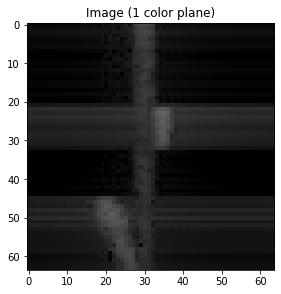

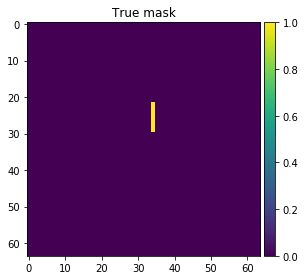

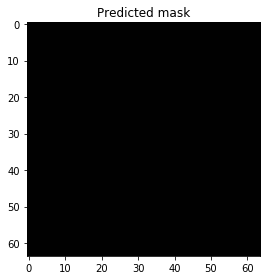

In [45]:
# Perform a sanity check on some random training samples
img_idx = random.randint(0, len(preds_train_t)-1)
color_idx = random.randint(0, IMG_CHANNELS-1)

imshow(X_train[img_idx,:,:,color_idx])
plt.title("Image (1 color plane)")
plt.show()
plt.title("True mask")
imshow(np.squeeze(Y_train[img_idx]))
plt.show()
plt.title("Predicted mask")
imshow(np.squeeze(preds_train_t[img_idx]))
plt.show()

In [ ]:
# Perform a sanity check on some random validation samples
img_idx = random.randint(0, len(preds_val_t)-1)
color_idx = random.randint(0, IMG_CHANNELS-1)

imshow(X_train[img_idx,:,:,color_idx])
plt.title("Image (1 color plane)")
plt.show()
plt.title("True mask")
imshow(np.squeeze(Y_train[img_idx]))
plt.show()
plt.title("Predicted mask")
imshow(np.squeeze(preds_train_t[img_idx]))
plt.show()

---

# Test code

In [ ]:
# show all images
for img in X_train:
    imshow(img[:,:,15])
    plt.show()

In [ ]:
# show all masks
for mask in Y_train:
    imshow(np.squeeze(mask))
    plt.show()